In [1]:
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

load the model

In [2]:
# Load the YOLOv5 trained model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='DetectionModel.pt', force_reload=False)


Using cache found in C:\Users\yushe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-5 Python-3.11.10 torch-2.3.1 CPU

Fusing layers... 
Model summary: 367 layers, 46154948 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


 Predict and visualize oner img,ca;culate height width area of wheel

         xmin        ymin        xmax        ymax  confidence  class      name
0  823.788086  505.770172  951.032410  649.708557    0.982451      0      tire
1  292.166321  444.643646  885.962097  685.237610    0.971822      5  bodyside
2   40.842823  422.463379  982.701782  776.805359    0.948858      2      body
3  212.137283  641.416870  354.022888  784.971436    0.937070      0      tire
4  398.891663  375.786560  755.832153  497.022125    0.898165      4       dlo
5  344.884125  364.768860  772.174927  511.949036    0.862651      3     cabin
6  240.503860  673.498230  329.153870  763.780579    0.831020      1     wheel
7  844.815552  536.572205  930.932495  622.802185    0.431141      1     wheel
8  235.750122  671.032593  331.209259  766.468445    0.374868      0      tire
      height      width         area
6  90.282349  88.650009  8003.531033
7  86.229980  86.116943  7425.862344


C:\Users\yushe\AppData\Local\Temp\ipykernel_16292\2175614314.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
C:\Users\yushe\AppData\Local\Temp\ipykernel_16292\2175614314.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
C:\Users\yushe\AppData\Local\Temp\ipykernel_16292\2175614314.py:19: SettingWithCopyWarning: 
A value is trying to be 

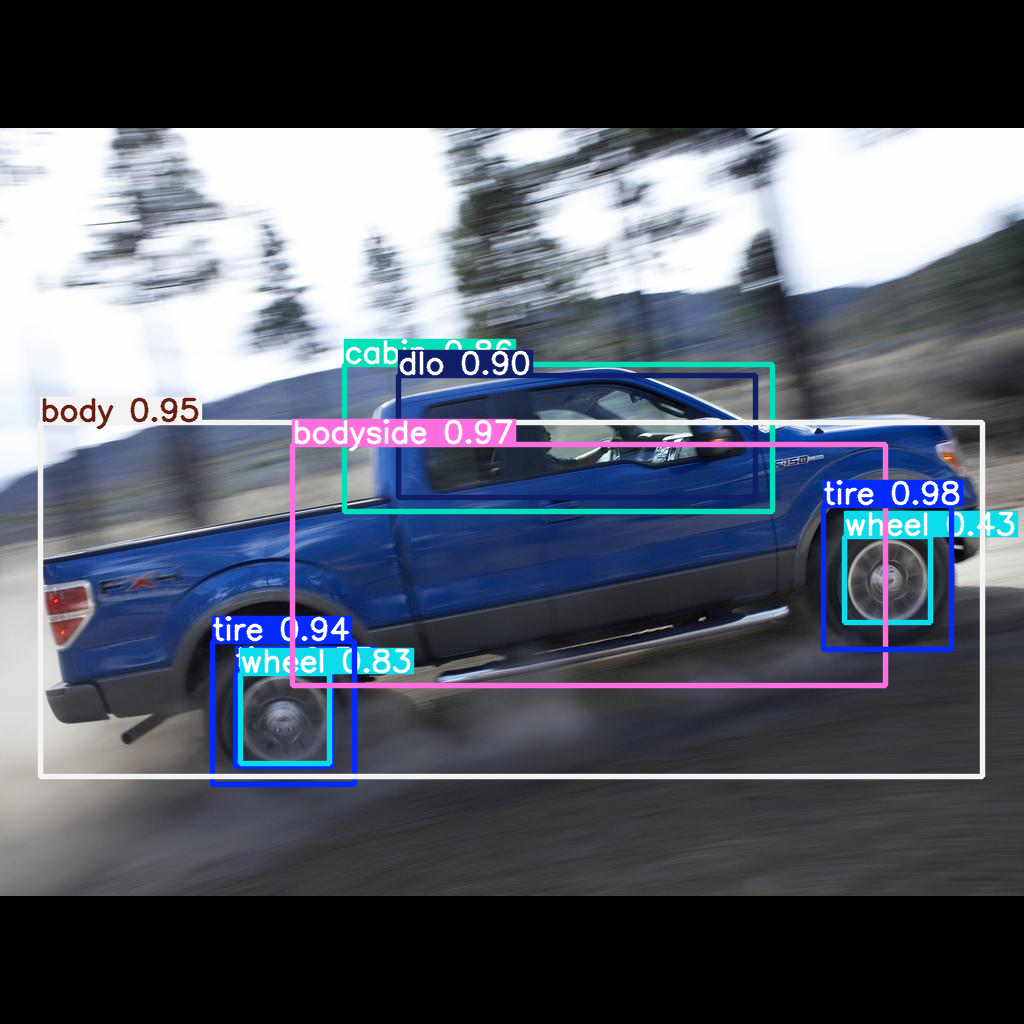

Saved 1 image to runs\detect5


In [3]:
 #Load the image you want to predict
image_path = "C:\Project\TRA235\yusheng\M_Hyu_04.jpg"  # Replace with your image file path
image_path="C:\Project\TRA235\yusheng\yusheng (1)\yusheng\P_For_39.jpg"
image = Image.open(image_path)

# Perform inference
results = model(image)
predictions = results.pandas().xyxy[0]  # Predictions in pandas DataFrame format
# Print results
print(results.pandas().xyxy[0])  # Predictions in pandas DataFrame format

# Filter for "wheel" class (class == 1 or name == "wheel")
wheel_predictions = predictions[predictions["name"] == "wheel"]

# Calculate the height of the wheels
if not wheel_predictions.empty:
    wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
    wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
    wheel_predictions["area"] = (wheel_predictions["xmax"] - wheel_predictions["xmin"])*(wheel_predictions["ymax"]-wheel_predictions["ymin"])
    #print("Wheel Heights:")
    print(wheel_predictions[[ "height","width","area"]])
else:
    print("No wheels detected in the image.")



# Visualize the results
results.show()

# Save the results image (optional)
#results.save(save_dir='runs/detect/')  # Save predictions to 'runs/detect/' directory

Predict All .jpg Images in a Folder

In [ ]:
import os
import pandas as pd
# Specify input and output folders
input_folder = "path_to_your_input_folder"  # Replace with the folder containing your .jpg images
output_folder = "path_to_your_output_folder"  # Replace with the folder to save results

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)
all_results = []

# Loop through all .jpg files in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".jpg"):  # Check for .jpg files
        image_path = os.path.join(input_folder, file_name)
        
        
        # Load and predict the image
        results = model(image_path)
         # Convert predictions to pandas DataFrame
        predictions = results.pandas().xyxy[0]

        # Filter for wheels
        wheel_predictions = predictions[predictions["name"] == "wheel"]

        # Calculate height, width, and area for wheels
        if not wheel_predictions.empty:
            wheel_predictions["height"] = wheel_predictions["ymax"] - wheel_predictions["ymin"]
            wheel_predictions["width"] = wheel_predictions["xmax"] - wheel_predictions["xmin"]
            wheel_predictions["area"] = wheel_predictions["height"] * wheel_predictions["width"]

        # Append the prediction and wheel data to the results list
        for _, row in predictions.iterrows():
            result = {
                "image": file_name,
                "xmin": row["xmin"],
                "ymin": row["ymin"],
                "xmax": row["xmax"],
                "ymax": row["ymax"],
                "confidence": row["confidence"],
                "class": row["class"],
                "name": row["name"],
            }
            if row["name"] == "wheel":
                # Add wheel-specific calculations
                result["height"] = row["ymax"] - row["ymin"]
                result["width"] = row["xmax"] - row["xmin"]
                result["area"] = (row["ymax"] - row["ymin"]) * (row["xmax"] - row["xmin"])
            else:
                # Non-wheel objects
                result["height"] = None
                result["width"] = None
                result["area"] = None

            all_results.append(result)
        # Save the result image with detections to the output folder
        #results.save(save_dir=output_folder)

        #print(f"Saved results for {file_name} to {output_folder}")
results_df = pd.DataFrame(all_results)

# Save the results to a CSV file
output_csv = os.path.join(output_folder, "predictions_with_wheel_dimensions.csv")
results_df.to_csv(output_csv, index=False)
print(f"Saved all results to {output_csv}")
print("Processing completed!")
